In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

# Example of analysis of gene transcript data on chromosome 13

### This Jupyter notebook presents an in-depth analysis of gene transcript data on chromosome 13.

### The analysis is divided into several key parts, each providing valuable insights into the genetic characteristics of the transcripts and their associated metrics. The following parts are covered in the notebook:

* #### [Selection only protein-coding transcripts from NCBI or Ensembl with pLoF-variants](#part1)
* #### [Collecting total AC and variant count per transcript](#part2)
* #### [Creating AC/N metric](#part3)
* #### [Adding expression data](#part4)
* #### [Adding LOEUF per transcript](#additional)
* #### [Collecting data per gene](#part5)
* #### [Adding LOEUF metric per gene](#part6)
* #### [Distribution of genes into groups by AC/N_range metric and LOEUF metric](#part7)

In [2]:
variant_data = pd.read_csv('/home/bioinf/gnomad-variants/Grishchenko/processed_data/tables/gnomad13.tsv', sep='\t', low_memory=False)
# This data is not available from the github repository due to its large size

In [3]:
variant_data

,CHROM,POS,ID,REF,ALT,AC,AC_afr,AC_amr,AC_nfe,AC_asj,...,BIOTYPE,EXON,INTRON,ALLELE_NUM,VARIANT_CLASS,CANONICAL,LoF,LoF_filter,LoF_flags,LoF_info
0,chr13,18173866,rs1387319788,T,C,4,0,0,4,0,...,unprocessed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
1,chr13,18173874,NaN,G,A,2,0,0,2,0,...,unprocessed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
2,chr13,18173891,NaN,CA,C,1,0,0,1,0,...,unprocessed_pseudogene,NaN,NaN,1,deletion,YES,NaN,NaN,NaN,NaN
3,chr13,18173896,NaN,T,C,4,0,0,0,0,...,unprocessed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
4,chr13,18173900,NaN,A,T,3,0,0,3,0,...,unprocessed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22334109,chr13,114346759,rs1263782924,T,C,2,0,0,2,0,...,processed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
22334110,chr13,114346761,rs2087386691,A,G,1,1,0,0,0,...,processed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
22334111,chr13,114346777,NaN,G,T,1,0,0,0,0,...,processed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN
22334112,chr13,114346781,rs1272633650,A,G,6,3,1,1,0,...,processed_pseudogene,NaN,NaN,1,SNV,YES,NaN,NaN,NaN,NaN


### <a id="part1">Selection only protein-coding transcripts from NCBI or Ensembl with pLoF-variants</a>

In [4]:
conseq_in_prot = variant_data[
    (variant_data['Feature_Type'] == 'Transcript') & 
    (variant_data['BIOTYPE'] == 'protein_coding') ]

values_to_filter = ['stop_gained', 'frameshift_variant', 'splice_donor_variant', 'splice_acceptor_variant']

filtered_conseq_in_prot = conseq_in_prot[conseq_in_prot['Consequence'].isin(values_to_filter)]

filtered_conseq_in_prot_ref = filtered_conseq_in_prot[filtered_conseq_in_prot['Feature'].str.contains('ENST|NM')]

### <a id="part2">Collecting total AC and variant count per transcript</a>

In [5]:
sum_ac_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')['AC']

transcript_list = []

for key, group in sum_ac_per_transcript:
    transcript_list.append(key)

sum_ac_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')['AC']

sum_ac = []

for key, group in sum_ac_per_transcript:
    unique_values = group.sum()
    sum_ac.append(unique_values)

population_ac = ['AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin']

sum_population_ac = [[], [], [], [], [], [], [], []]


for idx, el in enumerate(population_ac):
    sum_population = []
    sum_AC_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')[el]
    for key, group in sum_AC_per_transcript:
        unique_values = group.sum()
        sum_population.append(unique_values)
        sum_population_ac[idx].append(sum(sum_population))
        sum_population = []

gene_name_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')['SYMBOL']
gene_names = []

for key, group in gene_name_per_transcript:
    unique_values = group.unique()  # Extract the unique values
    gene_names.extend(unique_values)

gene_id_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')['Gene']

gene_id = []

for key, group in gene_id_per_transcript:
    unique_values = group.unique()  # Extract the unique values
    gene_id.extend(unique_values)

alt_per_transcript = filtered_conseq_in_prot_ref.groupby('Feature')['ALT']

alt_sum = []

for key, group in alt_per_transcript:
    unique_values = len(group.sum())
    alt_sum.append(unique_values)

In [6]:
transcripts_df_ac_nlog1 = pd.DataFrame({
    'Transcript_ID': transcript_list,
    'AC': np.log1p(sum_ac),
    'AC_afr': np.log1p(sum_population_ac[0]),
    'AC_amr': np.log1p(sum_population_ac[1]),
    'AC_nfe': np.log1p(sum_population_ac[2]),
    'AC_asj': np.log1p(sum_population_ac[3]),
    'AC_sas': np.log1p(sum_population_ac[4]),
    'AC_eas': np.log1p(sum_population_ac[5]),
    'AC_mid': np.log1p(sum_population_ac[6]),
    'AC_fin': np.log1p(sum_population_ac[7]),
    'Gene_name': gene_names,
    'Gene_id': gene_id,
    'Variant': alt_sum
})

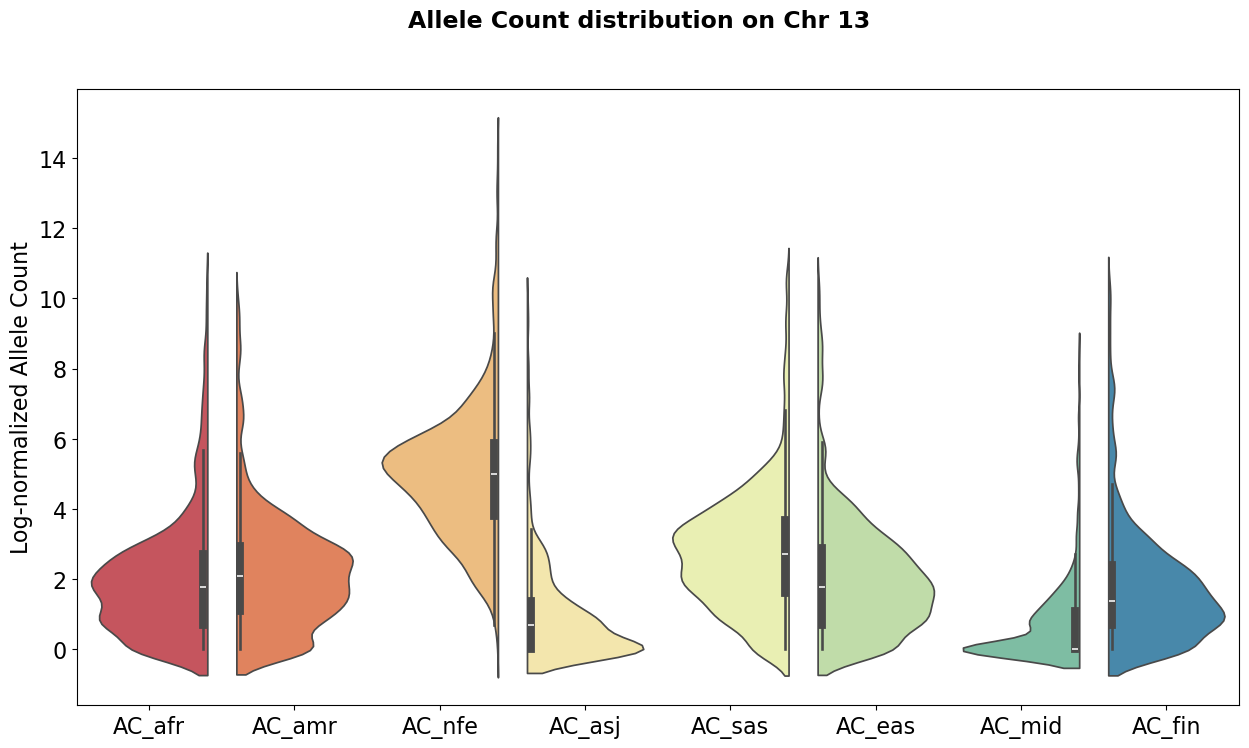

In [7]:
plt.figure(figsize=(15, 8))
custom_palette = sns.color_palette("Spectral", 8)
ax = sns.violinplot(data=transcripts_df_ac_nlog1[['AC_afr', 'AC_amr', 'AC_nfe', 'AC_asj', 'AC_sas', 'AC_eas', 'AC_mid', 'AC_fin']], palette=custom_palette, split=True)
ax.set_ylabel('Log-normalized Allele Count', fontsize=16) 
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.suptitle('Allele Count distribution on Chr 13', fontsize=17, fontweight='bold')
plt.savefig('../data/plots/Allele_Count_distribution.png', bbox_inches='tight')
plt.show()

In [8]:
transcripts_df_ac = pd.DataFrame({
    'Transcript_ID': transcript_list,
    'AC': sum_ac,
    'AC_afr': sum_population_ac[0],
    'AC_amr': sum_population_ac[1],
    'AC_nfe': sum_population_ac[2],
    'AC_asj': sum_population_ac[3],
    'AC_sas': sum_population_ac[4],
    'AC_eas': sum_population_ac[5],
    'AC_mid': sum_population_ac[6],
    'AC_fin': sum_population_ac[7],
    'Gene_name': gene_names,
    'Gene_id': gene_id,
    'Variant': alt_sum
})
transcripts_df_ac

,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant
0,ENST00000025301,136,3,4,98,1,11,5,0,10,AKAP11,ENSG00000023516,132
1,ENST00000181383,441,33,39,182,1,132,14,4,4,CPB2,ENSG00000080618,110
2,ENST00000196169,147,2,4,117,0,12,4,0,1,TDRD3,ENSG00000083544,132
3,ENST00000218548,4690,2069,239,1650,68,230,40,13,59,ATP12A,ENSG00000075673,231
4,ENST00000218652,124,5,2,84,0,4,21,0,3,NDFIP2,ENSG00000102471,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,NM_206827.2,186,9,5,143,0,6,3,0,1,RASL11A,387496,56
2277,NM_206937.2,1173,57,37,957,1,54,18,4,6,LIG4,3981,184
2278,NM_207304.3,21,1,1,15,0,1,1,0,1,MBNL2,10150,48
2279,NM_207361.6,825,21,34,650,5,45,12,9,11,FREM2,341640,398


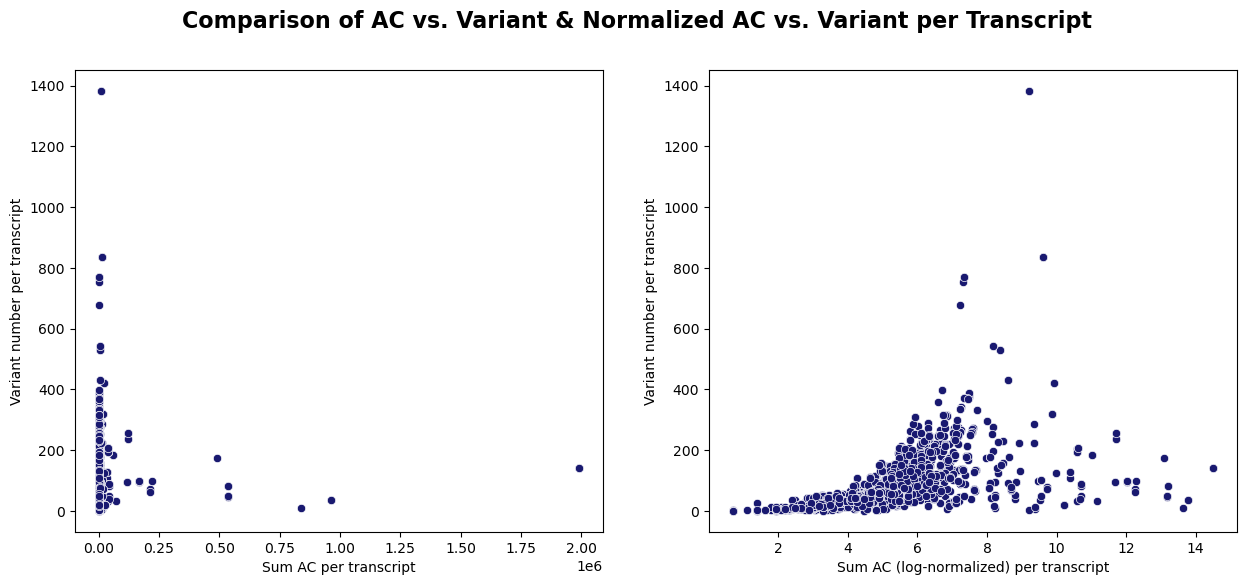

In [9]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='AC', y='Variant', data=transcripts_df_ac, color='midnightblue')
plt.xlabel('Sum AC per transcript')
plt.ylabel('Variant number per transcript')

plt.subplot(1, 2, 2)
sns.scatterplot(x='AC', y='Variant', data=transcripts_df_ac_nlog1, color='midnightblue')
plt.xlabel('Sum AC (log-normalized) per transcript')
plt.ylabel('Variant number per transcript')

plt.suptitle('Comparison of AC vs. Variant & Normalized AC vs. Variant per Transcript', fontsize=16, fontweight='bold')

plt.savefig('../data/plots/Comparison_AC_Variant.png', bbox_inches='tight')
plt.show()

#### At this stage, we have decided to retain only the data from the Ensembl database, as there is no expression data available for the transcripts from NCBI

In [10]:
transcripts_df_ac_enst = transcripts_df_ac[transcripts_df_ac['Transcript_ID'].str.contains('ENST')]
transcripts_df_ac_enst

,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant
0,ENST00000025301,136,3,4,98,1,11,5,0,10,AKAP11,ENSG00000023516,132
1,ENST00000181383,441,33,39,182,1,132,14,4,4,CPB2,ENSG00000080618,110
2,ENST00000196169,147,2,4,117,0,12,4,0,1,TDRD3,ENSG00000083544,132
3,ENST00000218548,4690,2069,239,1650,68,230,40,13,59,ATP12A,ENSG00000075673,231
4,ENST00000218652,124,5,2,84,0,4,21,0,3,NDFIP2,ENSG00000102471,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,ENST00000693040,1173,57,37,957,1,54,18,4,6,LIG4,ENSG00000174405,184
1218,ENST00000693100,262,4,4,230,0,11,2,0,0,EXOSC8,ENSG00000120699,39
1219,ENST00000693262,21,1,3,10,0,2,2,0,1,NBEA,ENSG00000172915,18
1220,ENST00000693488,53,0,2,49,0,2,0,0,0,POLR1D,ENSG00000186184,38


In [11]:
transcripts_df_ac_enst['Gene_name'].nunique()

310

### <a id="part3">Creating AC/N metric</a>

In [12]:
transcripts_df_ac_enst.loc[:, 'AC/Variant'] = transcripts_df_ac['AC'] / transcripts_df_ac['Variant']
transcripts_df_ac_enst

/tmp/ipykernel_2215746/2733858523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df_ac_enst.loc[:, 'AC/Variant'] = transcripts_df_ac['AC'] / transcripts_df_ac['Variant']


,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant,AC/Variant
0,ENST00000025301,136,3,4,98,1,11,5,0,10,AKAP11,ENSG00000023516,132,1.030303
1,ENST00000181383,441,33,39,182,1,132,14,4,4,CPB2,ENSG00000080618,110,4.009091
2,ENST00000196169,147,2,4,117,0,12,4,0,1,TDRD3,ENSG00000083544,132,1.113636
3,ENST00000218548,4690,2069,239,1650,68,230,40,13,59,ATP12A,ENSG00000075673,231,20.303030
4,ENST00000218652,124,5,2,84,0,4,21,0,3,NDFIP2,ENSG00000102471,74,1.675676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,ENST00000693040,1173,57,37,957,1,54,18,4,6,LIG4,ENSG00000174405,184,6.375000
1218,ENST00000693100,262,4,4,230,0,11,2,0,0,EXOSC8,ENSG00000120699,39,6.717949
1219,ENST00000693262,21,1,3,10,0,2,2,0,1,NBEA,ENSG00000172915,18,1.166667
1220,ENST00000693488,53,0,2,49,0,2,0,0,0,POLR1D,ENSG00000186184,38,1.394737


In [13]:
print("Missing values:")
print(transcripts_df_ac_enst.isnull().any())

print("\nMissing values in 'Gene_name':")
print(transcripts_df_ac_enst.loc[transcripts_df_ac_enst['Gene_name'].isnull()])

Missing values:
Transcript_ID    False
AC               False
AC_afr           False
AC_amr           False
AC_nfe           False
AC_asj           False
AC_sas           False
AC_eas           False
AC_mid           False
AC_fin           False
Gene_name         True
Gene_id          False
Variant          False
AC/Variant       False
dtype: bool

Missing values in 'Gene_name':
        Transcript_ID   AC  AC_afr  AC_amr  AC_nfe  AC_asj  AC_sas  AC_eas  \
522   ENST00000409186  201       5       9     165       4       7       4   
868   ENST00000611641   64       3       1      45       1       0      13   
969   ENST00000635838  241       0       4     227       1       4       0   
990   ENST00000638101  246       0       4     232       1       4       0   
992   ENST00000638147  313       2       7     280       1       8       2   
1162  ENST00000684204   34       0       0      28       0       2       0   

      AC_mid  AC_fin Gene_name          Gene_id  Variant  AC/Variant  


In [14]:
transcripts_df_ac_enst['Gene_name'].fillna(transcripts_df_ac_enst['Gene_id'], inplace=True)
print(transcripts_df_ac_enst.isnull().any())

Transcript_ID    False
AC               False
AC_afr           False
AC_amr           False
AC_nfe           False
AC_asj           False
AC_sas           False
AC_eas           False
AC_mid           False
AC_fin           False
Gene_name        False
Gene_id          False
Variant          False
AC/Variant       False
dtype: bool


/tmp/ipykernel_2215746/1653734856.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transcripts_df_ac_enst['Gene_name'].fillna(transcripts_df_ac_enst['Gene_id'], inplace=True)
/tmp/ipykernel_2215746/1653734856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df_ac_enst['Gene_name'].fillna(transcripts_df_ac_enst['Gene_id'], inp

In [15]:
transcripts_df_ac_enst['Gene_name'].nunique()

314

### <a id="part4">Adding expression data</a>

In [16]:
expression_metric = pd.read_csv('../data/max_tissue_median_expr.tsv', delimiter='\t')
# This data is available from the github repository from 'data' directory

In [17]:
expression_metric.head()

,ID_transcript,ID_gene,Max_median_expression
0,ENST00000373020.8,ENSG00000000003.14,47.10
1,ENST00000494424.1,ENSG00000000003.14,17.97
2,ENST00000496771.5,ENSG00000000003.14,22.57
3,ENST00000612152.4,ENSG00000000003.14,3.51
4,ENST00000614008.4,ENSG00000000003.14,48.55


In [18]:
transcripts = transcripts_df_ac_enst['Transcript_ID'].unique()
expression = []

for transcript in transcripts:
    expression_level = list(expression_metric[expression_metric['ID_transcript'].str.contains(transcript)]['Max_median_expression'])
    try:
        expression.append(expression_level[0])
    except:
        expression.append(np.nan)
len(expression)

1222

In [19]:
transcripts_df_ac_enst.loc[:,'Max_median_expression'] = expression
transcripts_df_ac_enst

/tmp/ipykernel_2215746/2404995749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df_ac_enst.loc[:,'Max_median_expression'] = expression


,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant,AC/Variant,Max_median_expression
0,ENST00000025301,136,3,4,98,1,11,5,0,10,AKAP11,ENSG00000023516,132,1.030303,13.97
1,ENST00000181383,441,33,39,182,1,132,14,4,4,CPB2,ENSG00000080618,110,4.009091,220.65
2,ENST00000196169,147,2,4,117,0,12,4,0,1,TDRD3,ENSG00000083544,132,1.113636,1.23
3,ENST00000218548,4690,2069,239,1650,68,230,40,13,59,ATP12A,ENSG00000075673,231,20.303030,0.00
4,ENST00000218652,124,5,2,84,0,4,21,0,3,NDFIP2,ENSG00000102471,74,1.675676,12.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,ENST00000693040,1173,57,37,957,1,54,18,4,6,LIG4,ENSG00000174405,184,6.375000,NaN
1218,ENST00000693100,262,4,4,230,0,11,2,0,0,EXOSC8,ENSG00000120699,39,6.717949,NaN
1219,ENST00000693262,21,1,3,10,0,2,2,0,1,NBEA,ENSG00000172915,18,1.166667,NaN
1220,ENST00000693488,53,0,2,49,0,2,0,0,0,POLR1D,ENSG00000186184,38,1.394737,NaN


In [20]:
transcripts_df_ac_enst['Gene_name'].nunique()

314

### <a id="additional">Adding LOEUF per transcript</a>

In [21]:
constraint_transcript = pd.read_csv('/home/bioinf/gnomad-variants/raw_data/plof_metrics/gnomad.v4.1.constraint_metrics.tsv', sep='\t')
# This data is not available from the github repository due to its large size
constraint_transcript.head()

,gene,gene_id,transcript,canonical,mane_select,lof_hc_lc.obs,lof_hc_lc.exp,lof_hc_lc.possible,lof_hc_lc.oe,lof_hc_lc.mu,...,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,level,transcript_type,chromosome,cds_length,num_coding_exons
0,A1BG,1,NM_130786.4,True,True,45.0,43.048,193.0,1.04540,7.063300e-07,...,0.973,1.172,-1.166000,-0.635490,[],NaN,NaN,NaN,NaN,NaN
1,A1BG,ENSG00000121410,ENST00000263100,True,True,45.0,43.048,193.0,1.04540,7.063300e-07,...,0.973,1.172,-1.166000,-0.635490,[],2.0,protein_coding,chr19,1485.0,8.0
2,A1BG,ENSG00000121410,ENST00000600966,False,False,24.0,26.268,123.0,0.91365,4.197900e-07,...,0.817,1.055,0.964250,0.525560,[],1.0,protein_coding,chr19,917.0,5.0
3,A1CF,29974,NM_001198818.2,False,False,45.0,69.962,352.0,0.64320,9.547100e-07,...,0.903,1.103,0.032727,0.017838,[],NaN,NaN,NaN,NaN,NaN
4,A1CF,29974,NM_001198819.2,False,False,48.0,72.811,367.0,0.65924,1.017600e-06,...,0.888,1.086,0.300030,0.163530,[],NaN,NaN,NaN,NaN,NaN


In [22]:
columns_to_keep = ['gene', 'gene_id', 'transcript', 'canonical', 'lof.oe_ci.upper']
constraint_transcript_loeuf = constraint_transcript[columns_to_keep]
constraint_transcript_loeuf

,gene,gene_id,transcript,canonical,lof.oe_ci.upper
0,A1BG,1,NM_130786.4,True,1.340
1,A1BG,ENSG00000121410,ENST00000263100,True,1.340
2,A1BG,ENSG00000121410,ENST00000600966,False,1.256
3,A1CF,29974,NM_001198818.2,False,0.825
4,A1CF,29974,NM_001198819.2,False,0.853
...,...,...,...,...,...
211518,NaN,ENSG00000289346,ENST00000625377,True,0.871
211519,NaN,ENSG00000289503,ENST00000553426,True,NaN
211520,NaN,ENSG00000289517,ENST00000617178,True,NaN
211521,NaN,ENSG00000289565,ENST00000632040,True,NaN


In [23]:
matched_values = constraint_transcript_loeuf[constraint_transcript_loeuf['transcript'].isin(transcripts_df_ac_enst['Transcript_ID'])]
matched_values.reset_index(inplace=True)
transcripts_df_ac_enst['lof_transcript'] = matched_values['lof.oe_ci.upper']
transcripts_df_ac_enst

/tmp/ipykernel_2215746/2129203239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df_ac_enst['lof_transcript'] = matched_values['lof.oe_ci.upper']


,Transcript_ID,AC,AC_afr,AC_amr,AC_nfe,AC_asj,AC_sas,AC_eas,AC_mid,AC_fin,Gene_name,Gene_id,Variant,AC/Variant,Max_median_expression,lof_transcript
0,ENST00000025301,136,3,4,98,1,11,5,0,10,AKAP11,ENSG00000023516,132,1.030303,13.97,0.636
1,ENST00000181383,441,33,39,182,1,132,14,4,4,CPB2,ENSG00000080618,110,4.009091,220.65,0.638
2,ENST00000196169,147,2,4,117,0,12,4,0,1,TDRD3,ENSG00000083544,132,1.113636,1.23,0.647
3,ENST00000218548,4690,2069,239,1650,68,230,40,13,59,ATP12A,ENSG00000075673,231,20.303030,0.00,0.700
4,ENST00000218652,124,5,2,84,0,4,21,0,3,NDFIP2,ENSG00000102471,74,1.675676,12.34,0.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,ENST00000693040,1173,57,37,957,1,54,18,4,6,LIG4,ENSG00000174405,184,6.375000,NaN,NaN
1218,ENST00000693100,262,4,4,230,0,11,2,0,0,EXOSC8,ENSG00000120699,39,6.717949,NaN,NaN
1219,ENST00000693262,21,1,3,10,0,2,2,0,1,NBEA,ENSG00000172915,18,1.166667,NaN,NaN
1220,ENST00000693488,53,0,2,49,0,2,0,0,0,POLR1D,ENSG00000186184,38,1.394737,NaN,NaN


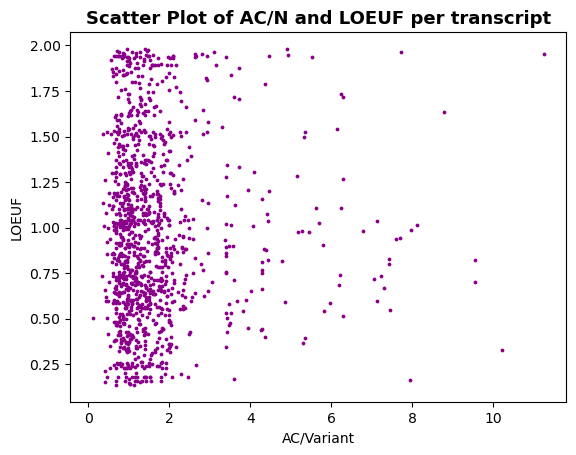

In [24]:
plt.scatter(np.log1p(transcripts_df_ac_enst['AC/Variant']), transcripts_df_ac_enst['lof_transcript'], s=3, color = 'darkmagenta')
plt.xlabel('AC/Variant')
plt.ylabel('LOEUF')
plt.title('Scatter Plot of AC/N and LOEUF per transcript', fontsize=13, fontweight='bold')
plt.savefig('../data/plots/AC_N_LOEUF_transcript.png', bbox_inches='tight')
plt.show()

### <a id="part5">Collecting data per gene</a>

In [25]:
genes = transcripts_df_ac_enst['Gene_name'].unique()
genes_min = []
genes_max = []
genes_acn_range = []
median_mean_expression = []

for gene in genes:
    list_ac_var = list(transcripts_df_ac_enst.loc[transcripts_df_ac_enst['Gene_name'] == gene]['AC/Variant'])
    if len(list_ac_var) > 1:
        genes_min.append(min(list_ac_var))
        genes_max.append(max(list_ac_var))
        if min(list_ac_var) == max(list_ac_var):
            genes_acn_range.append(max(list_ac_var))
        else:
            genes_acn_range.append((max(list_ac_var)/min(list_ac_var)))
    else:
        genes_min.append(min(list_ac_var))
        genes_max.append(max(list_ac_var))
        genes_acn_range.append(max(list_ac_var))
    list_expression = list(transcripts_df_ac_enst.loc[transcripts_df_ac_enst['Gene_name'] == gene]['Max_median_expression'])
    if len(list_ac_var) > 1:
        median_mean_expression.append(statistics.median(list_expression))
    else:
        median_mean_expression.append(max(list_expression))

print(len(genes), len(genes_acn_range), len(genes_min), len(genes_max), len(median_mean_expression))

314 314 314 314 314


### <a id="part6">Adding LOEUF metric per gene</a>

In [26]:
plof_metrics_genes = pd.read_table('/home/bioinf/gnomad-variants/raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
# This data is not available from the github repository due to its large size

In [27]:
loeuf = []
for gene in genes:
    e_lof = list(plof_metrics_genes.loc[plof_metrics_genes['gene'] == gene]['oe_lof_upper'])
    try:
        loeuf.append(e_lof[0])
    except:
        loeuf.append(None)
len(loeuf)

314

In [28]:
genes_conserv = pd.DataFrame({
    'Gene_name': genes,
    'AC/N_min': genes_min,
    'AC/N_max': genes_max,
    'AC/N_range': genes_acn_range,
    'LOEUF': loeuf,
    'Max_median_expression': median_mean_expression 
}).sort_values(by='AC/N_range', ascending=False)
genes_conserv

,Gene_name,AC/N_min,AC/N_max,AC/N_range,LOEUF,Max_median_expression
86,TPT1,1.000000,76186.454545,76186.454545,0.485,97.100
251,ALOX5AP,0.600000,27507.885714,45846.476190,0.963,158.610
58,SLAIN1,0.500000,14123.184397,28246.368794,0.375,0.390
249,TEX26,6516.341463,6516.341463,6516.341463,1.399,20.520
103,FARP1,0.500000,2190.310000,4380.620000,0.509,2.090
...,...,...,...,...,...,...
216,MZT1,0.882353,0.882353,0.882353,1.707,13.170
204,SPRY2,0.852941,0.852941,0.852941,0.273,48.980
23,RAP2A,0.833333,0.833333,0.833333,0.479,15.035
238,LHFPL6,0.690476,0.690476,0.690476,NaN,166.200


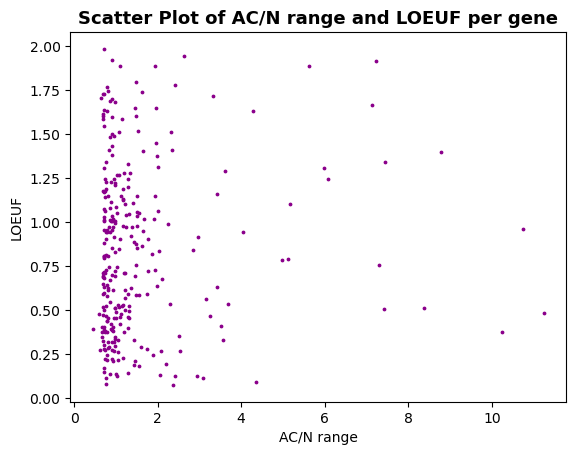

In [29]:
plt.scatter(np.log1p(genes_conserv['AC/N_range']), genes_conserv['LOEUF'], s=3, color = 'darkmagenta')
plt.xlabel('AC/N range')
plt.ylabel('LOEUF')
plt.title('Scatter Plot of AC/N range and LOEUF per gene', fontsize=13, fontweight='bold')
plt.savefig('../data/plots/AC_N_LOEUF_gene.png', bbox_inches='tight')
plt.show()

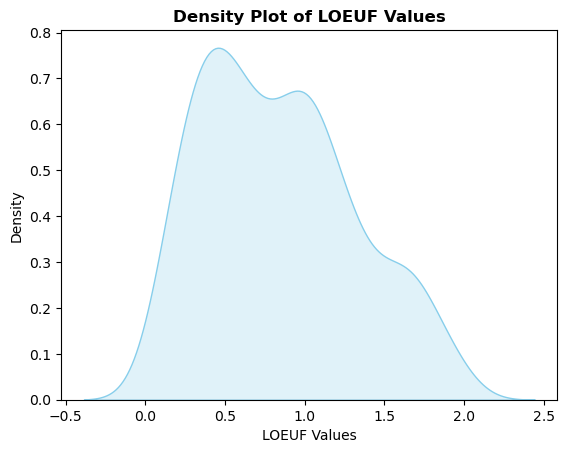

In [30]:
sns.kdeplot(genes_conserv['LOEUF'], color='skyblue', fill=True)
plt.xlabel('LOEUF Values')
plt.ylabel('Density')
plt.title('Density Plot of LOEUF Values', fontsize=12, fontweight='bold')
plt.savefig('../data/plots/Density_LOEUF.png', bbox_inches='tight')
plt.show()

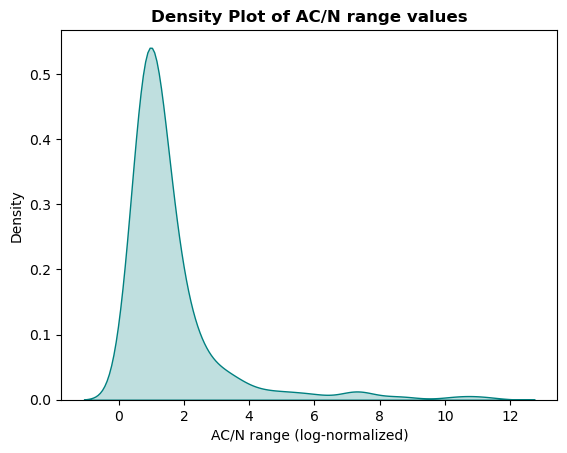

In [31]:
sns.kdeplot(np.log1p(genes_conserv['AC/N_range']), color='teal', fill=True)
plt.xlabel('AC/N range (log-normalized)')
plt.ylabel('Density')
plt.title('Density Plot of AC/N range values', fontsize=12, fontweight='bold')
plt.savefig('../data/plots/Density_AC_N_range.png', bbox_inches='tight')
plt.show()

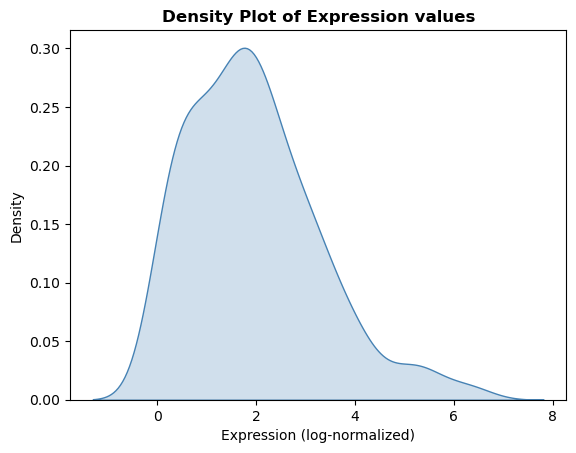

In [32]:
sns.kdeplot(np.log1p(genes_conserv['Max_median_expression']), color='steelblue', fill=True)
plt.xlabel('Expression (log-normalized)')
plt.ylabel('Density')
plt.title('Density Plot of Expression values', fontsize=12, fontweight='bold')
plt.savefig('../data/plots/Density_Expression.png', bbox_inches='tight')
plt.show()

### <a id="part7">Distribution of genes into groups by AC/N_range metric and LOEUF metric</a>

In [33]:
range_values = genes_conserv['AC/N_range']

In [34]:
mean_range = statistics.mean(range_values)

In [35]:
median_range = statistics.median(range_values)

In [36]:
q1 = np.percentile(range_values, 33.33)
median = np.percentile(range_values, 66.67)
q3 = np.percentile(range_values, 100)
print(q1, median, q3)

1.4118422645497564 2.885672982456141 76186.45454545454


In [37]:
def define_group_range(range):
    if range <= q1 and range > 1: # all transcripts are very similar (AC/N both small and large), AC/N for each transcript >= 1
        return 0
    elif range >= q3: # The gene exhibits a substantial variation in the presence of AC and N in loss-of-function variants across various transcripts.
        return 3
    elif range < 1:
        return 2      # few transcripts, all N > AC
    else:
        return 1 # All transcripts of the gene exhibit an AC/N ratio greater than or equal to 1.

def define_group_loeuf(range):
    if range == None:
        return None
    if range < 0.35:
        return 0 # the gene highly LoF intolerant 
    elif range > 0.75:
        return 2 # the gene is LoF tolerant
    else:
        return 1 # the gene is moderately LoF tolerant

In [38]:
genes_conserv['range_group_custom'] = genes_conserv['AC/N_range'].apply(define_group_range)
genes_conserv['range_group_custom'] = genes_conserv['range_group_custom'].astype('category')

genes_conserv['range_group_loeuf'] = genes_conserv['LOEUF'].apply(define_group_loeuf)
genes_conserv['range_group_loeuf'] = genes_conserv['range_group_loeuf'].astype('category')
genes_conserv

,Gene_name,AC/N_min,AC/N_max,AC/N_range,LOEUF,Max_median_expression,range_group_custom,range_group_loeuf
86,TPT1,1.000000,76186.454545,76186.454545,0.485,97.100,3,1
251,ALOX5AP,0.600000,27507.885714,45846.476190,0.963,158.610,1,2
58,SLAIN1,0.500000,14123.184397,28246.368794,0.375,0.390,1,1
249,TEX26,6516.341463,6516.341463,6516.341463,1.399,20.520,1,2
103,FARP1,0.500000,2190.310000,4380.620000,0.509,2.090,1,1
...,...,...,...,...,...,...,...,...
216,MZT1,0.882353,0.882353,0.882353,1.707,13.170,2,2
204,SPRY2,0.852941,0.852941,0.852941,0.273,48.980,2,0
23,RAP2A,0.833333,0.833333,0.833333,0.479,15.035,2,1
238,LHFPL6,0.690476,0.690476,0.690476,NaN,166.200,2,1


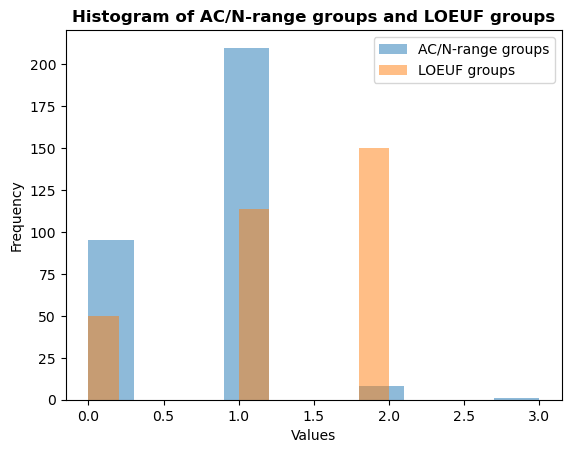

In [39]:
fig, ax = plt.subplots()

ax.hist(genes_conserv['range_group_custom'], alpha=0.5, label='AC/N-range groups')
ax.hist(genes_conserv['range_group_loeuf'], alpha=0.5, label='LOEUF groups')

ax.legend()

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of AC/N-range groups and LOEUF groups', fontsize=12, fontweight='bold')
plt.savefig('../data/plots/AC_N_range_LOEUF_groups.png', bbox_inches='tight')
plt.show()

#### Appending data to file

In [40]:
#genes_conserv.to_csv('../data/processed_data/ac_expression_tables/genes_1.tsv', sep='\t', index=False)